# Day 2 - Finding Neighbours

In [1]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}

def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

In [83]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time

### Reading the lens/source catalog

In [90]:
# !head -n 5 /home/idies/workspace/Storage/navin/persistent/demo_objects.csv
# !wc -l /home/idies/workspace/Storage/navin/persistent/demo_objects.csv

In [91]:
#reading lens file

#tries to read everthing in the file
df = pd.read_csv(f"/home/idies/workspace/Storage/navin/persistent/demo_objects.csv", sep=',') 

\# a brief look of what dataFrame has for us-


In [92]:
df.head()

,ra,dec,z,col_3,col_4,col_5
0,30.611735,-6.356909,23.901826,23.043298,22.649281,0.50
1,30.610781,-6.350381,22.385773,21.548382,21.272576,0.38
2,30.596478,-6.346152,23.948118,23.121471,22.773187,0.37
3,30.592680,-6.344521,23.427314,22.022286,21.334948,0.45
4,30.601111,-6.338650,21.660045,20.812223,20.383688,0.32


\# select required columns only

In [93]:
df = pd.read_csv(f"/home/idies/workspace/Storage/navin/persistent/demo_objects.csv", sep=',', usecols=[0,1,2])

In [95]:
df.head()

,ra,dec,z
0,30.611735,-6.356909,23.901826
1,30.610781,-6.350381,22.385773
2,30.596478,-6.346152,23.948118
3,30.592680,-6.344521,23.427314
4,30.601111,-6.338650,21.660045


### Visualising the coordinate space of input data

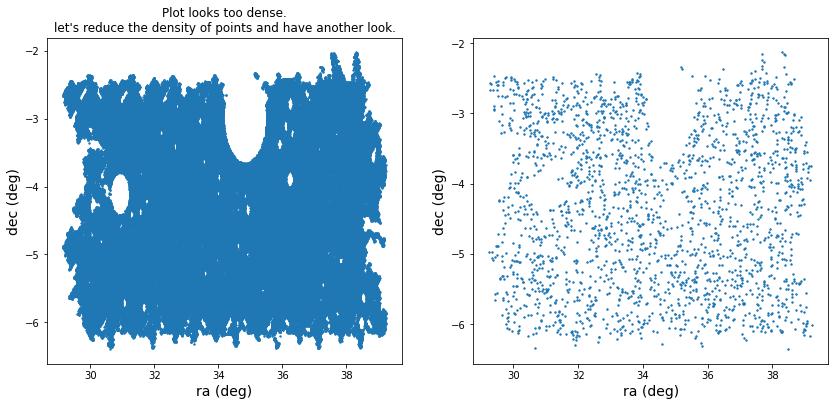

In [96]:
fig,ax = plt.subplots(1,2, figsize=(14,6))
ax1,ax2 = ax

#plot all the coordinates   
ax1.scatter(df.ra.values,df.dec.values, s=2)
ax1.set_xlabel("ra (deg)", fontsize=14)
ax1.set_ylabel("dec (deg)", fontsize=14)

ax1.set_title("Plot looks too dense.\nlet's reduce the density of points and have another look.")

#Randomly picking up points to plots to reduce the density of points
Number_of_points = df.ra.size
down_sample_by = 100
random_indices = np.random.choice(np.arange(Number_of_points), 
                                  size=int(Number_of_points/down_sample_by), 
                                  replace=False)
#plot down sampled number coordinates
ax2.scatter(df.ra.values[random_indices], df.dec.values[random_indices], s=2)
ax2.set_xlabel("ra (deg)", fontsize=14)
ax2.set_ylabel("dec (deg)", fontsize=14)

plt.show()

### `On-sky distance` between two points on the surface of a unit sphere

#### Method 1
$\cos(\theta)=\frac{\vec{r_1}\cdot\vec{r_2}}{r_1 r_2}$ <br>

set $r_1=r_2=1$ 

get $\theta$

Using: $\mathrm{arc\_distance}=s=r \times \theta$, obtain the distance between the two ra,dec values.
Since $r_1=r_2=1$, 

$\Rightarrow s=\theta$ (radians)

In [11]:
rad_to_arcsec = 180.0*3600./np.pi
arcsec_to_rad = 1/rad_to_arcsec

def dotprod_dist(obj1,obj2):
    """dot prod formula"""
    ra1,dec1 = obj1
    ra2,dec2 = obj2
    arg = np.cos(np.deg2rad(dec2))* np.cos(np.deg2rad(dec1))* np.cos(np.deg2rad(ra1) - np.deg2rad(ra2)) + np.sin(np.deg2rad(dec1))* np.sin(np.deg2rad(dec2))
    if arg>1.0:
        #the problematic ones which are being set to 1.0 are different from 1.0 at a decimal point which is beyond the precision level supported by the ra,dec's themselves. 
        arg = 1.0
    dist = np.arccos(arg)* rad_to_arcsec
    return dist


#### Method 2:
Equatorial coordinates (ra,dec) $\equiv$ $(\phi,\delta)$

For a given pair of objects, $(\phi_1,\delta_1)$ and $(\phi_2,\delta_2)$

3D distance: 
$d{r}=\sqrt{\left( \Delta \phi \cdot \cos(\frac{\delta_1+\delta_2}{2}) \right)^2 + (\Delta \delta)^2}$

In [99]:
def dist_betw_two_obj(obj1,obj2):
    #3D distance between two points
    #ra1,dec1,ra2,dec2=np.loadtxt(fname,unpack=1)
    ra1,dec1 = obj1
    ra2,dec2 = obj2
    dra=(ra1-ra2)*np.cos(np.deg2rad(dec1/2.+dec2/2.))
    ddec=dec1-dec2
    #print "Ang sep (deg,mins,sec):",dist, dist*60, dist*3600
    return np.sqrt(dra**2+ddec**2)*3600.0 #*3600 gives value in arcsec


### Comparison between the distance computation codes
arc\_distance vs 3D distance

In [100]:
# creating tuple of values from ra,dec of each object
coords = list( zip(df.ra.values,df.dec.values))

In [101]:
#comparing two formulae
dotprod_dist(coords[0],coords[1]), dist_betw_two_obj(coords[0],coords[1])

(23.7466131834144, 23.746613375392588)

### `Brute force search for neighbour objects` within a specified distance 
time complexity ~ $\mathcal{O}(n^2)$ 

In [102]:
from collections import defaultdict

def find_neighbour_points(coords, rmax=10):
    """
    finding neighbour objects within some distance, for all the objects in a given array of coordinates.
    
    coords: an array/list of tuples (ra,dec)
    
    Returns:
    `nnids`: indices into `coords` of neighbours of each object in `coords` within `rmax`
    `distances`: distance of objects matched in `nnids"""

    # define containers for the distance and id information of matched objects
    distances = defaultdict(list)
    nnids = defaultdict(list)

    c=0
    for ii,obj1 in enumerate(coords):
        c+=1
        d=0
        for jj,obj2 in enumerate(coords):
            if jj==ii:
                continue
            d+=1
            dist = dist_betw_two_obj(obj1,obj2)
            if dist <= rmax:
                nnids[ii].append(jj)
                distances[ii].append(dist)
        print(ii,nnids[ii],distances[ii])                
    return nnids,distances

def query_neighbour_point(coords1, coords2, rmax=10):
    """
    coords1: a tuple or an array/list of tuples (ra,dec)
    coords2: an array/list of tuples (ra,dec)
    
    Returns:
    `nnids`: indices into `coords2` of neighbours of each object `coords1` within `rmax`.
    `distances`: distance of objects matched in `nnids`"""

    coords1 = np.atleast_2d(coords1)
    
    # define containers for the distance and id information of matched objects
    distances = defaultdict(list)
    nnids = defaultdict(list)

    for ii,obj1 in enumerate(coords1):
        for jj,obj2 in enumerate(coords2):
            dist = dist_betw_two_obj(obj1,obj2)
            if dist <= rmax:
                nnids[ii].append(jj)
                distances[ii].append(dist)
        print(ii,nnids[ii],distances[ii])                
    return nnids,distances

### Searching within a ball of radius `rmax` of `one specified object` 
using `query_neighbour_point` function (brute force search)

For `rmax`(default value)=15 arcsec

In [103]:
print(f"For an object having index of {nth} in the catalog:")

For an object having index of 15 in the catalog:


In [104]:
test_object = coords[nth]
print("No, neighbours found, distances to neighbours ")
%time nnidsx, distancesx = query_neighbour_point(test_object,coords,rmax=15)

No, neighbours found, distances to neighbours 
0 [14, 15, 16, 44] [5.475958131239454, 0.0, 13.479755086756219, 10.276694368285947]
CPU times: user 4.91 s, sys: 0 ns, total: 4.91 s
Wall time: 4.91 s


In [105]:
print(f"""Accessing the neighbour points for the '{nth}'th object using the output 
of our brute force method:""")
print(nnidsx[0], distancesx[0])

print(f"neighbours: {nnids[nth]} \ndistances: {distances[nth]}")
print()

print(f"Accessing the neighbour coordinates of the {nth}th object:")
for ii in nnidsx[0]:
    print(ii, coords[ii])

Accessing the neighbour points for the '15'th object using the output 
of our brute force method:
[14, 15, 16, 44] [5.475958131239454, 0.0, 13.479755086756219, 10.276694368285947]
neighbours: [14, 16, 44] 
distances: [5.475958131239454, 13.479755086756219, 10.276694368285947]

Accessing the neighbour coordinates of the 15th object:
14 (30.564297942270603, -6.322030429805476)
15 (30.56561715299634, -6.321259374304455)
16 (30.562347805639572, -6.319398928221537)
44 (30.568297869918087, -6.3202347701814166)


### Search within a ball of radius `rmax` of all the objects in a catalog 
using `find_neighbour_points` function (brute force search)

For `rmax`(default value)=15 arcsec

In [106]:
# from time import time 
# t=time()
# nnids,distances = find_neighbour_points(coords[:100],rmax=15)
# print(f"total time taken to run = {time()-t}")

%time nnids,distances = find_neighbour_points(coords[:10],rmax=15)

0 [] []
1 [] []
2 [3] [14.802299170813551]
3 [2] [14.802299170813551]
4 [36] [13.682331444812649]
5 [] []
6 [] []
7 [] []
8 [13] [9.46553729170334]
9 [10, 12, 38] [10.946803628195813, 5.876628556475439, 14.594679816593928]
10 [9, 12] [10.946803628195813, 10.28060110962467]
11 [42] [7.1517256212952995]
12 [9, 10, 14] [5.876628556475439, 10.28060110962467, 11.314135857330662]
13 [8] [9.46553729170334]
14 [12, 15, 16] [11.314135857330662, 5.475958131239454, 11.76585438073485]
15 [14, 16, 44] [5.475958131239454, 13.479755086756219, 10.276694368285947]
16 [14, 15] [11.76585438073485, 13.479755086756219]
17 [46] [6.898088994114847]
18 [55] [8.53424262342414]
19 [] []
20 [] []
21 [] []
22 [] []
23 [] []
24 [] []
25 [26] [13.299083171910977]
26 [25] [13.299083171910977]
27 [] []
28 [] []
29 [30] [3.691834241752694]
30 [29] [3.691834241752694]
31 [] []
32 [] []
33 [] []
34 [] []
35 [36] [10.896870584428063]
36 [4, 35] [13.682331444812649, 10.896870584428063]
37 [] []
38 [9, 40] [14.594679816593

In [107]:
nth = 15
print(f"""Accessing the neighbour points for the {nth}th object using the output 
of our brute force method:""")

print(f"neighbours: {nnids[nth]} \ndistances: {distances[nth]}")

print()

print(f"Accessing the neighbour coordinates of the {nth}th object:")
for ii in nnids[nth]:
    print(ii, coords[ii])

Accessing the neighbour points for the 15th object using the output 
of our brute force method:
neighbours: [14, 16, 44] 
distances: [5.475958131239454, 13.479755086756219, 10.276694368285947]

Accessing the neighbour coordinates of the 15th object:
14 (30.564297942270603, -6.322030429805476)
16 (30.562347805639572, -6.319398928221537)
44 (30.568297869918087, -6.3202347701814166)


---

### A visual sanity check for execution of `find_neighbour_points`  function

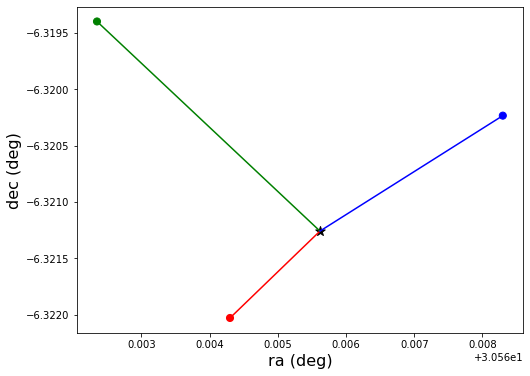

index--> distance		color
14 ---> 5.475958131239454 	 r
16 ---> 13.479755086756219 	 g
44 ---> 10.276694368285947 	 b


In [108]:
demoid = 15

plt.figure(figsize=(8,6))
#plot demo point
demora,demodec  = coords[demoid] 
plt.scatter(demora,demodec, c='black', s=100, marker=r'*')

#access all the neighbours
coords=np.array(coords)
neighbours = nnids[demoid]

#choose colors for a given number of neighbours
colors = ['r','g','b']
# colors = np.random.random( size=(len(neighbours),3) )

#plot all the neighbour points
plotra  = [coord[0] for coord in coords[neighbours] ]
plotdec = [coord[1] for coord in coords[neighbours] ] 
plt.scatter(plotra, plotdec, c=colors, s=50, marker='o')

for i in range(len(plotra)):
    plt.plot([demora,plotra[i]],[demodec,plotdec[i]] , c=colors[i])

plt.xlabel("ra (deg)", fontsize=16)
plt.ylabel("dec (deg)", fontsize=16)
plt.show()
# plt.savefig("first.png",bbox_inches="tight")

# Now visuall compare the distances
print("index--> distance\t\tcolor")
ndist = distances[demoid]
for nidx,dist,c in zip(neighbours,ndist,colors):
    print(nidx,"--->",dist, '\t', c)

---

### Using k-d tree algorithm to query the neighbour points within a given distance 
time complexity ~ $\mathcal{O}(n\log{}n)$ 

#### We'll use the `spatial.cKDTree` package from `scipy`.

If you have many points whose neighbors you want to find, you may save substantial amounts of time by putting them in a `cKDTree` and using functions defined on this tree. For example: `query_ball_point`

In [109]:
from scipy import spatial
sin = np.sin
cos = np.cos
deg2rad = np.deg2rad

### Write a wrapper code using cKDTree to find out the neighbours of a given `set1` of objects (coordinates) from a catalog of other objects, `set2`

\# Write this code in a `class structure` where it takes-in arrays of `ra,dec` of the catalog objects (set2) and 
- converts (ra,dec) to (x,y,z) of cartesian coordinates.
- creates k-d tree of the catalog objects using (x,y,x)
- queries for the neighbour points of each object in the `set1` using its ra,dec 

In [110]:
class find_neighbours:
    def __init__(self, tra=None, tdec=None, r=1):
        """r==1 --> unit sphere calculations"""
        self.tra = tra
        self.tdec= tdec
        self.r = r
        self.rad_to_arcsec = 180.0*3600./np.pi
        self.arcsec_to_rad = 1/self.rad_to_arcsec
        
        if r==1:
            print("You are working with a unit sphere.")
        else:
            print(f"You are NOT working with a unit sphere, r={r}")
        
    # write a function that converts ra,dec to cartesian components.
    def RA_DEC_to_xyz(self, ra,dec, units='deg'):
        """converts ra,dec to cartesian x,y,z components on a unit sphere"""
        if units=="deg":
            ra = deg2rad(ra)
            dec= deg2rad(dec)
            
        x = self.r *cos(dec) *cos(ra)
        y = self.r *cos(dec) *sin(ra)
        z = self.r *sin(dec)
        return x,y,z 

    # write a function `create_tree` that takes arrays of ra,dec 
    # values as inputs and returns a cKDTree object into these coordinates.
    
    def create_tree(self):
        # create an array of tuples of x,y,z
        x,y,z = self.RA_DEC_to_xyz(self.tra,self.tdec)
        # make a tree using cKDTree method 
        tree = spatial.cKDTree(np.c_[x,y,z])
        return tree

    # write a function that takes arrays of ra,dec coordinates
    # and returns the neighbour object's indices from the tree 
    # within some distance `rmax` arcsec .
    
    def query_within_rmax(self, ra, dec, rmax=15, units="deg"):
        #convert rmax from arcsec to distance units
        rmax = self.r *rmax *self.arcsec_to_rad 
        
        # array of tuples of x,y,z of input objetcs
        x,y,z = self.RA_DEC_to_xyz(ra,dec)
        cartesian_coords = np.c_[x,y,z]

        # make tree from catalog
        tree = self.create_tree()
        
        # look for the neighbour objects
        ids_into_tree = tree.query_ball_point(cartesian_coords,rmax)
        
        return ids_into_tree

#### Testing conversion of (ra,dec) to (x,y,z) 

In [111]:
code = find_neighbours()

# a look at the cartesian coordinates
x,y,z = code.RA_DEC_to_xyz(coords[:,0], coords[:,1])
cartesian_coords = np.c_[x,y,z]

print("shapes of x,y,z arrays:",x.shape,y.shape,z.shape)
print("shapes of (x,y,z) tuple array:", cartesian_coords.shape)
#field on objects looks close to equator
cartesian_coords

You are working with a unit sphere.
shapes of x,y,z arrays: (220622,) (220622,) (220622,)
shapes of (x,y,z) tuple array: (220622, 3)


array([[ 0.8553461 ,  0.50608675, -0.11072151],
       [ 0.85536537,  0.50607894, -0.11060828],
       [ 0.85549871,  0.50586954, -0.11053492],
       ...,
       [ 0.78796508,  0.6142163 , -0.04300421],
       [ 0.78737094,  0.61497898, -0.04298683],
       [ 0.78774839,  0.61449982, -0.04292369]])

#### Demo objects for which we'll compare the output of our brute force algorithm with cKDTree algorithm

\# Take the same bunch of objects for which we already have run our brute force search method,
and feed them into the wrapper code of k-d tree written above, and find out their neighbour points
within the same `rmax`(default value)=15 arcsec.


In [119]:
demo_ids = [15] #9,15
demo_ra =coords[demo_ids,0] #deg
demo_dec=coords[demo_ids,1] #deg

demox, demoy, demoz = code.RA_DEC_to_xyz(demo_ra, demo_dec)
demoobj = np.c_[demox,demoy,demoz]
print("indices of test objects in set2(catalog):",demo_ids)
print("coordinate of test objects:",demoobj)

# we want to look within `rmax` arcsec --> convert `rmax` from (arcsec) angle to length units

rmax = 15 * arcsec_to_rad
# print()
# print(f"rmax={rmax} in radians:",rmax)

indices of test objects in set2(catalog): [15]
coordinate of test objects: [[ 0.85581232  0.50543305 -0.11010311]]


\# Initialize class and set up the tree

In [113]:
code_tree = find_neighbours(tra=coords[:,0], tdec=coords[:,1])

You are working with a unit sphere.


\# Query the neighbours of demo objects 

In [114]:
idx=code_tree.query_within_rmax(demo_ra, demo_dec)

\# Go back to brute force output and compare this result.... does it match? 

In [115]:
idx

array([list([14, 15, 16, 44])], dtype=object)